<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/08_natural_Language_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Tensorflow

The main goal of natural language processing(NLP) is to derive information from natural language. It is concerned with text and speech and covers fields like email spam classification, twitter sentiment analysis, and machine translation.

In this section we will cover:
* Downloading text data
* Visualizing it
* Converting text into numbers using tokenization
* Model a text dataset
- * Starting with a baseline (TD-IDF)
* * Building deep learning text models
* * * Dense, LSTM, GRU, Conv1D, Transfer Learning
* Compare the performance of each model
* Combining models into an ensemble
* Saving and loading a pretrained model
* Finding the most wrong predictions

In [1]:
# import datetime
# print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

## Check for GPU

In [2]:
!nvidia-smi

Thu Jul 18 10:07:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Fetch helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-18 10:07:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-18 10:07:46 (22.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download text dataset
We'll start by using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) dataset from Kaggle which conntains text-based Tweets about natural disasters

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# unzip data
unzip_data("nlp_getting_started.zip")

--2024-07-18 10:07:54--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2024-07-18 10:07:54 (38.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing the text dataset

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# shuffle the training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# check how many examples for each class
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
len(train_df), len(test_df)

(7613, 3263)

## Visualize some of the text

In [11]:
import random
random_index = random.randint(0, len(train_df)-1)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target : {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text :\n{text}\n")
    print("-----------------------\n")

Target : 0 (not real disaster)
Text :
@Eric_Tsunami worry about yourself

-----------------------

Target : 0 (not real disaster)
Text :
#ThingsIhate 
Watching someone you care about head into total destruction and not being able to do anything.

-----------------------

Target : 0 (not real disaster)
Text :
@sethalphaeus my personal favorites include paramore muse green day royal blood and 5sos

-----------------------

Target : 1 (real disaster)
Text :
@FlyOpineMonkey You mean Olympic ;-) 
Also its follow-up for Honshu Operation Coronet. 
In all: 1m Allied casualties 30m Japanese dead.

-----------------------

Target : 0 (not real disaster)
Text :
Fairfax investigating firefighter over Facebook post saying police should be put in Û÷body bagsÛª - The Washington Post http://t.co/jAxHzjCCd4

-----------------------



In [12]:
# split data into training and validation sets
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2,
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6090, 6090, 1523, 1523)

## Converting text to numbers

In [14]:
# carrying out text vectorization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length
)


In [15]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

# create a sample sentence and tokenize it
sample_sentence = "There's a fire in my living room!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 240,    3,   44,    4,   13, 1169, 1080,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [16]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


## Creating an embedding layer

In [17]:
from tensorflow.keras import layers

tf.random.set_seed(42)
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length,
                             name='embedding_1')

embedding

In [18]:
# Make a sample embedding
sample_embed = embedding(text_vectorizer([sample_sentence]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04368677,  0.04484476,  0.04875392, ...,  0.03262288,
         -0.02120063, -0.04508732],
        [-0.03804366,  0.02914795,  0.01482182, ..., -0.0082574 ,
         -0.0349809 , -0.02971085],
        [ 0.01734843,  0.00492486, -0.01108676, ..., -0.02484263,
          0.01120595,  0.03253317],
        ...,
        [ 0.0354352 , -0.03951185,  0.03210847, ...,  0.00065559,
         -0.04589853,  0.04264087],
        [ 0.0354352 , -0.03951185,  0.03210847, ...,  0.00065559,
         -0.04589853,  0.04264087],
        [ 0.0354352 , -0.03951185,  0.03210847, ...,  0.00065559,
         -0.04589853,  0.04264087]]], dtype=float32)>

## Modelling a text dataset
Here we will be build different models and then we'll compare them to ko=now which ine performed best. The models we will be building include:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

### Model_0 (baseline)
To create our baseline model, we'll create a Scikit-Learn Pipeline using TD-IDF(term frequency-inverse document frequency) to convert words to numbers and then model them using Multinomial Naive Bayes algorithm

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
     ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model accuracy : {baseline_score*100:.2f}%")

Baseline model accuracy : 79.91%


In [21]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

### Creating an evaluation function for model experiments

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates a model's accuracy, precision, recall and f1-score
    Returns a dictionary of accuracy, precision, recall, f1-score
    """
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1-score": model_f1
    }
    return model_results

In [23]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.9080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'f1-score': 0.7920155324845473}

### Model_1 : Simple dense model

In [24]:
from helper_functions import create_tensorboard_callback
from tensorflow.keras import layers

SAVE_DIR = 'model_logs'

# using  the functional api to create the model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [25]:
# compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [27]:
# Fit
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20240718-100802
Epoch 1/5
191/191 [==============================] - 12s 49ms/step - loss: 0.6207 - accuracy: 0.6892 - val_loss: 0.5503 - val_accuracy: 0.7459
Epoch 2/5
191/191 [==============================] - 3s 14ms/step - loss: 0.4558 - accuracy: 0.8128 - val_loss: 0.4768 - val_accuracy: 0.7840
Epoch 3/5
191/191 [==============================] - 2s 9ms/step - loss: 0.3548 - accuracy: 0.8586 - val_loss: 0.4639 - val_accuracy: 0.7945
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.2881 - accuracy: 0.8890 - val_loss: 0.4645 - val_accuracy: 0.7886
Epoch 5/5
191/191 [==============================] - 2s 9ms/step - loss: 0.2390 - accuracy: 0.9115 - val_loss: 0.4756 - val_accuracy: 0.7925


In [28]:
model_1.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.7925


[0.4756072163581848, 0.7925148010253906]

In [29]:
# get model_1's weights
embed_weights = model_1.get_layer('embedding_1').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [30]:
# make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

48/48 [==============================] - 0s 3ms/step


array([[0.4269349 ],
       [0.87501764],
       [0.99702495],
       [0.14238752],
       [0.10456263],
       [0.9467892 ],
       [0.9682289 ],
       [0.99310255],
       [0.94068706],
       [0.29133904]], dtype=float32)

In [31]:
# turn model predictions into a single-dimesion tensor
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [32]:
# get model_1 metrics
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 79.25147734734077,
 'precision': 0.793940042369497,
 'recall': 0.7925147734734077,
 'f1-score': 0.7899403327179391}

In [33]:
# compare model_1 to baseline
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [34]:
# create helper function to do this comparison
def compare_baseline_to_model(new_model_results, baseline_results=baseline_results):
    for key, value, in baseline_results.items():
        print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

## Recurrent Neural Networks

### Model_2: LSTM

In [35]:
tf.random.set_seed(42)

# create new embedding layer
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length=max_length,
                                     name='embedding_1')

In [36]:
# create LSTM
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_2_embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x)  # return vector for each each word in the Tweet
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_lstm')

In [37]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [39]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_2_lstm')])

Saving TensorBoard log files to: model_logs/model_2_lstm/20240718-100825
Epoch 1/5
191/191 [==============================] - 9s 35ms/step - loss: 0.5143 - accuracy: 0.7417 - val_loss: 0.4573 - val_accuracy: 0.7840
Epoch 2/5
191/191 [==============================] - 3s 18ms/step - loss: 0.3076 - accuracy: 0.8768 - val_loss: 0.4953 - val_accuracy: 0.7840
Epoch 3/5
191/191 [==============================] - 2s 10ms/step - loss: 0.2047 - accuracy: 0.9246 - val_loss: 0.5801 - val_accuracy: 0.7794
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.1372 - accuracy: 0.9514 - val_loss: 0.8158 - val_accuracy: 0.7459
Epoch 5/5
191/191 [==============================] - 2s 9ms/step - loss: 0.0973 - accuracy: 0.9650 - val_loss: 0.8332 - val_accuracy: 0.7754


In [40]:
model_2.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.8332 - accuracy: 0.7754


[0.8331873416900635, 0.7754431962966919]

In [41]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

48/48 [==============================] - 1s 7ms/step


array([[0.0076676 ],
       [0.9110184 ],
       [0.9991968 ],
       [0.01992601],
       [0.00248676],
       [0.9993129 ],
       [0.87332994],
       [0.99972457],
       [0.9991578 ],
       [0.08817684]], dtype=float32)

In [42]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [43]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.54432042022324,
 'precision': 0.7801792175802764,
 'recall': 0.7754432042022325,
 'f1-score': 0.7706037408677304}

In [44]:
compare_baseline_to_model(model_2_results)

Baseline accuracy: 79.91, New accuracy: 77.54, Difference: -2.36
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1-score: 0.79, New f1-score: 0.77, Difference: -0.02


### Model 3 : GRU

In [45]:
# set random seed and create ambedding
tf.random.set_seed(42)
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length=max_length,
                                     name='embedding_3')

In [46]:
# build an RNN using GRU
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True)  # stacking recurrent GRU layers requires 'return_sentences=True'
x = layers.GRU(64)(x)
# layers.Dense(64, activation='relu')(x)  # optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_gru')

In [47]:
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [48]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_3_gru')])


Saving TensorBoard log files to: model_logs/model_3_gru/20240718-100850
Epoch 1/5
191/191 [==============================] - 18s 77ms/step - loss: 0.5366 - accuracy: 0.7232 - val_loss: 0.4574 - val_accuracy: 0.7853
Epoch 2/5
191/191 [==============================] - 8s 44ms/step - loss: 0.3131 - accuracy: 0.8700 - val_loss: 0.4820 - val_accuracy: 0.7912
Epoch 3/5
191/191 [==============================] - 4s 19ms/step - loss: 0.2062 - accuracy: 0.9240 - val_loss: 0.5617 - val_accuracy: 0.7827
Epoch 4/5
191/191 [==============================] - 3s 18ms/step - loss: 0.1426 - accuracy: 0.9504 - val_loss: 0.6717 - val_accuracy: 0.7597
Epoch 5/5
191/191 [==============================] - 2s 11ms/step - loss: 0.1092 - accuracy: 0.9637 - val_loss: 0.6998 - val_accuracy: 0.7879


In [49]:
model_3.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.7879


[0.6998116374015808, 0.7879185676574707]

In [50]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

48/48 [==============================] - 0s 2ms/step


array([[0.1990651 ],
       [0.9937691 ],
       [0.9996841 ],
       [0.03722142],
       [0.00417654],
       [0.99828523],
       [0.69546396],
       [0.99965656],
       [0.9963003 ],
       [0.10108037]], dtype=float32)

In [51]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 78.79185817465529,
 'precision': 0.7896711766803203,
 'recall': 0.7879185817465528,
 'f1-score': 0.7850215430717877}

In [53]:
compare_baseline_to_model(model_3_results)

Baseline accuracy: 79.91, New accuracy: 78.79, Difference: -1.12
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.80, New recall: 0.79, Difference: -0.01
Baseline f1-score: 0.79, New f1-score: 0.79, Difference: -0.01


### Model 4 : Bidirectional RNN model

In [54]:
tf.random.set_seed(42)

model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length=max_length,
                                     name='embedding_4')

In [55]:
# create bidirectional RNN
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [56]:
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [58]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240718-100928
Epoch 1/5
191/191 [==============================] - 22s 74ms/step - loss: 0.5144 - accuracy: 0.7443 - val_loss: 0.4595 - val_accuracy: 0.7873
Epoch 2/5
191/191 [==============================] - 3s 17ms/step - loss: 0.3023 - accuracy: 0.8791 - val_loss: 0.4974 - val_accuracy: 0.7879
Epoch 3/5
191/191 [==============================] - 3s 13ms/step - loss: 0.1972 - accuracy: 0.9287 - val_loss: 0.5957 - val_accuracy: 0.7702
Epoch 4/5
191/191 [==============================] - 3s 16ms/step - loss: 0.1327 - accuracy: 0.9524 - val_loss: 0.6626 - val_accuracy: 0.7452
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.0910 - accuracy: 0.9657 - val_loss: 0.8528 - val_accuracy: 0.7708


In [59]:
model_4.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 4ms/step - loss: 0.8528 - accuracy: 0.7708


[0.8527871966362, 0.7708470225334167]

In [60]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

48/48 [==============================] - 1s 3ms/step


array([[7.5824428e-03],
       [9.0787756e-01],
       [9.9930954e-01],
       [2.8503824e-02],
       [6.7863072e-04],
       [9.9672985e-01],
       [8.4263021e-01],
       [9.9984503e-01],
       [9.9897730e-01],
       [1.6193752e-01]], dtype=float32)

In [61]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.08470124753775,
 'precision': 0.7743559401653622,
 'recall': 0.7708470124753776,
 'f1-score': 0.7663578667549866}

### Model 5: Conv1D (temporal convolution)

In [62]:
# create embedding
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

In [63]:
# create model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1d')

In [64]:
# compile
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [65]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240718-101016
Epoch 1/5
191/191 [==============================] - 10s 38ms/step - loss: 0.5821 - accuracy: 0.7061 - val_loss: 0.4797 - val_accuracy: 0.7807
Epoch 2/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3486 - accuracy: 0.8535 - val_loss: 0.4797 - val_accuracy: 0.7991
Epoch 3/5
191/191 [==============================] - 2s 9ms/step - loss: 0.2070 - accuracy: 0.9246 - val_loss: 0.5492 - val_accuracy: 0.7800
Epoch 4/5
191/191 [==============================] - 2s 9ms/step - loss: 0.1277 - accuracy: 0.9570 - val_loss: 0.6327 - val_accuracy: 0.7571
Epoch 5/5
191/191 [==============================] - 2s 9ms/step - loss: 0.0900 - accuracy: 0.9711 - val_loss: 0.6886 - val_accuracy: 0.7768


In [66]:
model_5.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.7768


[0.6885821223258972, 0.7767564058303833]

In [67]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

48/48 [==============================] - 0s 2ms/step


array([[0.81221896],
       [0.98634094],
       [0.9988697 ],
       [0.01783166],
       [0.00254776],
       [0.9979091 ],
       [0.9816226 ],
       [0.9980842 ],
       [0.99773324],
       [0.12553638]], dtype=float32)

In [68]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [69]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 77.67564018384768,
 'precision': 0.7766135863624087,
 'recall': 0.7767564018384767,
 'f1-score': 0.7747944907380269}

In [70]:
compare_baseline_to_model(model_5_results)

Baseline accuracy: 79.91, New accuracy: 77.68, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1-score: 0.79, New f1-score: 0.77, Difference: -0.02


### Model 6: Transfer learning
Using the [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [71]:
import tensorflow_hub as hub

transfer_embedding = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = transfer_embedding([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.03726019  0.08410282  0.04451571 -0.02246935  0.08110346 -0.08460756
 -0.0090843   0.03017532  0.00334605 -0.02015906  0.05633597 -0.06644616
  0.0422302   0.07805345  0.01334831 -0.05765938  0.01536791 -0.03027908
  0.0666509  -0.01347031 -0.04394272 -0.05637369  0.0248158  -0.02491855
 -0.05381692  0.04214174  0.00911368 -0.02237407 -0.01823633 -0.02882441
 -0.02387102 -0.07229902 -0.01589181 -0.02705609 -0.08757906 -0.06225491
  0.08601914 -0.03813356 -0.00413594  0.0084443  -0.00945244  0.02812827
 -0.01589944  0.04415561 -0.09842718  0.03958895 -0.04446733  0.01508158
  0.00176149 -0.03930255], shape=(50,), dtype=float32)


In [72]:
embed_samples[0].shape

TensorShape([512])

In [73]:
# creating an embedding layer for model_6
sentence_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  input_shape=[],
                                  dtype=tf.string,
                                  trainable=False,
                                  name='universal_sentence_encoder')

In [74]:
# build model_6 using Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [75]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "transfer_learning")])

Saving TensorBoard log files to: model_logs/transfer_learning/20240718-101111
Epoch 1/5
191/191 [==============================] - 6s 16ms/step - loss: 0.5138 - accuracy: 0.7836 - val_loss: 0.4496 - val_accuracy: 0.7925
Epoch 2/5
191/191 [==============================] - 2s 13ms/step - loss: 0.4145 - accuracy: 0.8143 - val_loss: 0.4400 - val_accuracy: 0.7991
Epoch 3/5
191/191 [==============================] - 3s 13ms/step - loss: 0.3984 - accuracy: 0.8215 - val_loss: 0.4422 - val_accuracy: 0.8024
Epoch 4/5
191/191 [==============================] - 4s 23ms/step - loss: 0.3889 - accuracy: 0.8294 - val_loss: 0.4383 - val_accuracy: 0.8056
Epoch 5/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3826 - accuracy: 0.8292 - val_loss: 0.4383 - val_accuracy: 0.8083


In [76]:
model_6.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 9ms/step - loss: 0.4383 - accuracy: 0.8083


[0.43828222155570984, 0.8082731366157532]

In [77]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

48/48 [==============================] - 1s 8ms/step


array([[0.22849776],
       [0.8384281 ],
       [0.98631674],
       [0.16002032],
       [0.7846323 ],
       [0.7656183 ],
       [0.9816679 ],
       [0.98071986],
       [0.93362683],
       [0.11576812]], dtype=float32)

In [78]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [79]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.82731451083389,
 'precision': 0.8079966521244174,
 'recall': 0.8082731451083388,
 'f1-score': 0.8072426200486464}

### Model 7: Transfer learning with 10% data

In [80]:
# Split the data to get 10%
train_sentences_90, train_sentences_10, train_labels_90, train_labels_10 =train_test_split(np.array(train_sentences),
                                                                                           train_labels,
                                                                                           test_size=0.1,
                                                                                           random_state=42)

len(train_sentences_90), len(train_sentences_10), len(train_sentences)

(5481, 609, 6090)

In [81]:
# clone model_6
model_7 = tf.keras.models.clone_model(model_6)

# compile
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [82]:
model_7_history = model_7.fit(train_sentences_10,
                              train_labels_10,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "transfer_learning_10_percent")])

Saving TensorBoard log files to: model_logs/transfer_learning_10_percent/20240718-101137
Epoch 1/5
20/20 [==============================] - 5s 67ms/step - loss: 0.6753 - accuracy: 0.6634 - val_loss: 0.6524 - val_accuracy: 0.7308
Epoch 2/5
20/20 [==============================] - 1s 44ms/step - loss: 0.6202 - accuracy: 0.7915 - val_loss: 0.6026 - val_accuracy: 0.7485
Epoch 3/5
20/20 [==============================] - 1s 44ms/step - loss: 0.5587 - accuracy: 0.7898 - val_loss: 0.5555 - val_accuracy: 0.7610
Epoch 4/5
20/20 [==============================] - 1s 66ms/step - loss: 0.5049 - accuracy: 0.8079 - val_loss: 0.5210 - val_accuracy: 0.7689
Epoch 5/5
20/20 [==============================] - 1s 44ms/step - loss: 0.4643 - accuracy: 0.8161 - val_loss: 0.5015 - val_accuracy: 0.7708


In [83]:
model_7.evaluate(val_sentences, val_labels)

48/48 [==============================] - 1s 15ms/step - loss: 0.5015 - accuracy: 0.7708


[0.5014513731002808, 0.7708470225334167]

In [84]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

48/48 [==============================] - 1s 9ms/step


array([[0.3701339 ],
       [0.76862407],
       [0.8375847 ],
       [0.346593  ],
       [0.64867806],
       [0.84222466],
       [0.8500474 ],
       [0.8641279 ],
       [0.69394183],
       [0.30631822]], dtype=float32)

In [85]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [86]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.08470124753775,
 'precision': 0.7711408970276622,
 'recall': 0.7708470124753776,
 'f1-score': 0.7709775883783722}

In [87]:
compare_baseline_to_model(model_7_results)

Baseline accuracy: 79.91, New accuracy: 77.08, Difference: -2.82
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.80, New recall: 0.77, Difference: -0.03
Baseline f1-score: 0.79, New f1-score: 0.77, Difference: -0.02


## Comparing the performance of our Models

In [88]:
# combine all results into a dataframe
all_models_results_df = pd.DataFrame({"baseline": baseline_results,
                                      "simple_dense": model_1_results,
                                      "lstm": model_2_results,
                                      "gru": model_3_results,
                                      "bidirectional": model_4_results,
                                      "conv1d": model_5_results,
                                      "transfer_learning_100%": model_6_results,
                                      "transfer_learning_10%": model_7_results})
all_models_results_df = all_models_results_df.transpose()
all_models_results_df

,accuracy,precision,recall,f1-score
baseline,79.908076,0.814636,0.799081,0.792016
simple_dense,79.251477,0.793940,0.792515,0.789940
lstm,77.544320,0.780179,0.775443,0.770604
gru,78.791858,0.789671,0.787919,0.785022
bidirectional,77.084701,0.774356,0.770847,0.766358
conv1d,77.675640,0.776614,0.776756,0.774794
transfer_learning_100%,80.827315,0.807997,0.808273,0.807243
transfer_learning_10%,77.084701,0.771141,0.770847,0.770978


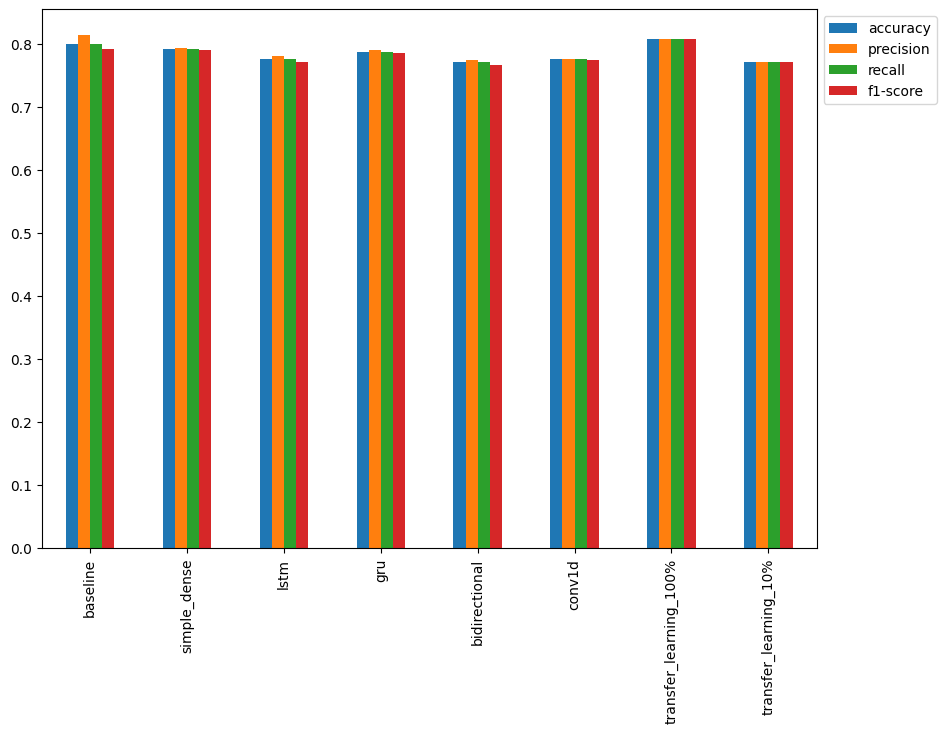

In [89]:
all_models_results_df['accuracy'] = all_models_results_df['accuracy'] / 100
all_models_results_df.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

## Model Stacking/Ensembling

In [93]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [94]:
# add ensemble results and add to results dictionary
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.44845699277742,
 'precision': 0.7939556528753237,
 'recall': 0.7944845699277742,
 'f1-score': 0.7935118867131726}

In [95]:
all_models_results_df = pd.DataFrame({"baseline": baseline_results,
                                      "simple_dense": model_1_results,
                                      "lstm": model_2_results,
                                      "gru": model_3_results,
                                      "bidirectional": model_4_results,
                                      "conv1d": model_5_results,
                                      "transfer_learning_100%": model_6_results,
                                      "transfer_learning_10%": model_7_results,
                                      "ensemble": ensemble_results})
all_models_results_df = all_models_results_df.transpose()
all_models_results_df

,accuracy,precision,recall,f1-score
baseline,79.908076,0.814636,0.799081,0.792016
simple_dense,79.251477,0.793940,0.792515,0.789940
lstm,77.544320,0.780179,0.775443,0.770604
gru,78.791858,0.789671,0.787919,0.785022
bidirectional,77.084701,0.774356,0.770847,0.766358
conv1d,77.675640,0.776614,0.776756,0.774794
transfer_learning_100%,80.827315,0.807997,0.808273,0.807243
transfer_learning_10%,77.084701,0.771141,0.770847,0.770978
ensemble,79.448457,0.793956,0.794485,0.793512


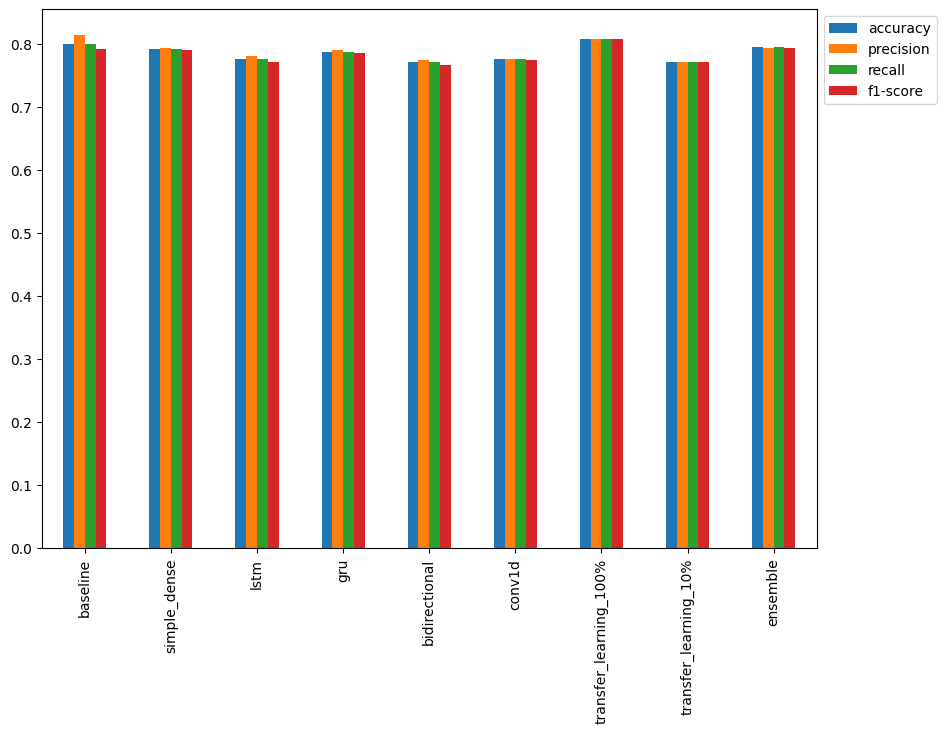

In [96]:
all_models_results_df['accuracy'] = all_models_results_df['accuracy'] / 100
all_models_results_df.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

## Finding the Most Wrong predictions

In [97]:
# create dataframe with validation data and best performing model predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

48/48 [==============================] - 0s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_probs": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.228498
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.838428
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986317
3,@camilacabello97 Internally and externally scr...,1,0.0,0.160020
4,Radiation emergency #preparedness starts with ...,1,1.0,0.784632


In [99]:
# find the wrong predictions and sort probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong.head(10)

,text,target,pred,pred_probs
881,@adorableappple No reported flooding po in the...,0,1.0,0.977314
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.960216
846,Mourning notices for stabbing arson victims st...,0,1.0,0.954162
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.944722
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.931583
759,FedEx will no longer transport bioterror patho...,0,1.0,0.927045
814,the MOFO in DC will leave our military unarmed...,0,1.0,0.901436
813,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.900105
1099,One thing you can be sure of. There will never...,0,1.0,0.899685
1467,Bloor/Ossington arsonist also burned a mattres...,0,1.0,0.898637


In [101]:
most_wrong.tail(10)

,text,target,pred,pred_probs
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.050582
38,Why are you deluged with low self-image? Take ...,1,0.0,0.049088
1448,the sunset boys wreck my bed original 1979 u...,1,0.0,0.048630
233,I get to smoke my shit in peace,1,0.0,0.045899
59,You can never escape me. Bullets don't harm me...,1,0.0,0.042197
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.041983
935,'I did another one I did another one. You stil...,1,0.0,0.041325
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.036242
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.034604
768,destroy the free fandom honestly,1,0.0,0.034402


In [102]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


Target: 0, Pred: 1, Prob: 0.9773135781288147
Text:
@adorableappple No reported flooding po in the area. Ten-4. #mmda

----

Target: 0, Pred: 1, Prob: 0.9602161645889282
Text:
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv

----

Target: 0, Pred: 1, Prob: 0.9541621208190918
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe

----

Target: 0, Pred: 1, Prob: 0.9447218179702759
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0, Pred: 1, Prob: 0.931583046913147
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9270453453063965
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pr

In [103]:
# function to predict on text
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [104]:
sample_tweet = "Life like an ensemble: take the best choices from others and make your own"
predict_on_sentence(model_6, sample_tweet)

1/1 [==============================] - 0s 38ms/step
Pred: 0.0 (not real disaster) Prob: 0.06635306030511856
Text:
Life like an ensemble: take the best choices from others and make your own


In [105]:
sample_tweet2_disaster = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"
predict_on_sentence(model_6, sample_tweet2_disaster)

1/1 [==============================] - 0s 36ms/step
Pred: 1.0 (real disaster) Prob: 0.96293044090271
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [106]:
import random

test_sentences = val_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for sample in test_samples:
    predict_on_sentence(model_6, sample)

1/1 [==============================] - 0s 35ms/step
Pred: 0.0 (not real disaster) Prob: 0.1938011199235916
Text:
#golf McIlroy fuels PGA speculation after video: Injured world number one Rory McIlroy fueled speculatio... http://t.co/dCyYJVmXHR #news
1/1 [==============================] - 0s 33ms/step
Pred: 1.0 (real disaster) Prob: 0.9163589477539062
Text:
@billy_hodge Aurora theater shooting trial: Gunman expected notoriety for mass murder and nothing else  http://t.co/1RPCHRu72C
1/1 [==============================] - 0s 32ms/step
Pred: 1.0 (real disaster) Prob: 0.5251079797744751
Text:
MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3
1/1 [==============================] - 0s 36ms/step
Pred: 1.0 (real disaster) Prob: 0.8261106014251709
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.
1/1 [==============================] - 0s 34ms/step
Pred: 0.0 (not real disaster) Prob: 0.

## Speed/Score Tradeoff

In [111]:
import time

def pred_timer(model, samples):
    start = time.perf_counter()
    model.predict(samples)
    end = time.perf_counter()
    total_time = end - start
    time_per_prediction = total_time / len(samples)
    return total_time, time_per_prediction

In [112]:
model_6_total_time, model_6_time_per_pred = pred_timer(model_6, test_samples)
model_6_total_time, model_6_time_per_pred


1/1 [==============================] - 0s 36ms/step


(0.09184465699991051, 0.00918446569999105)